# PDP Plots Comparison

This notebook compares the new `pdp_sk` and `pdp_sm` functions with the existing `pred_plot_sk` and `pred_plot_sm` functions across different model types.

Key differences:
- `pred_plot_*` (fast mode): Sets other variables to mean/mode, varies one variable
- `pdp_*` with `mode="pdp"`: True partial dependence - samples from data distribution and averages predictions

## Models covered:
1. Random Forest (classification & regression)
2. XGBoost (classification & regression)
3. MLP Neural Network (classification & regression)
4. Logistic Regression (pyrsm.logistic)
5. Linear Regression (pyrsm.regress)

In [1]:
import time
import polars as pl
import pyrsm as rsm
from pyrsm.model.rforest import rforest
from pyrsm.model.xgboost import xgboost
from pyrsm.model.mlp import mlp
from pyrsm.model.logistic import logistic
from pyrsm.model.regress import regress
from pyrsm.model.visualize import pdp_sk, pdp_sm, pred_plot_sk, pred_plot_sm

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

## Load Data

In [3]:
# Classification data
titanic, _ = rsm.load_data(pkg="model", name="titanic")
titanic = titanic.drop_nulls(subset=["age"])
print(f"Titanic: {titanic.shape}")
titanic.head()

Titanic: (1043, 10)


pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
cat,cat,cat,f64,i32,i32,f64,str,str,cat
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""


In [4]:
# Regression data
salary, _ = rsm.load_data(pkg="basics", name="salary")
print(f"Salary: {salary.shape}")
salary.head()

Salary: (397, 6)


salary,rank,discipline,yrs_since_phd,yrs_service,sex
i32,cat,cat,i32,i32,cat
139750,"""Prof""","""B""",19,18,"""Male"""
173200,"""Prof""","""B""",20,16,"""Male"""
79750,"""AsstProf""","""B""",4,3,"""Male"""
115000,"""Prof""","""B""",45,39,"""Male"""
141500,"""Prof""","""B""",40,41,"""Male"""


In [5]:
# Common variables
clf_evars = ["age", "sex", "pclass", "sibsp"]
reg_evars = ["yrs_since_phd", "yrs_service", "rank", "discipline"]

---
# 1. Random Forest

## 1a. Random Forest Classification

In [6]:
rf_clf = rforest(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", n_estimators=100, random_state=1234,
)
rf_clf.summary()

Random Forest
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
OOB                  : True
Model type           : classification
Nr. of features      : (4, 6)
Nr. of observations  : 1,043
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.813

Estimation data      :
shape: (5, 6)
┌────────┬───────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 0     ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 0.9167 ┆ 1     ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1     ┆ 1          

pred_plot_sk: 0.049s


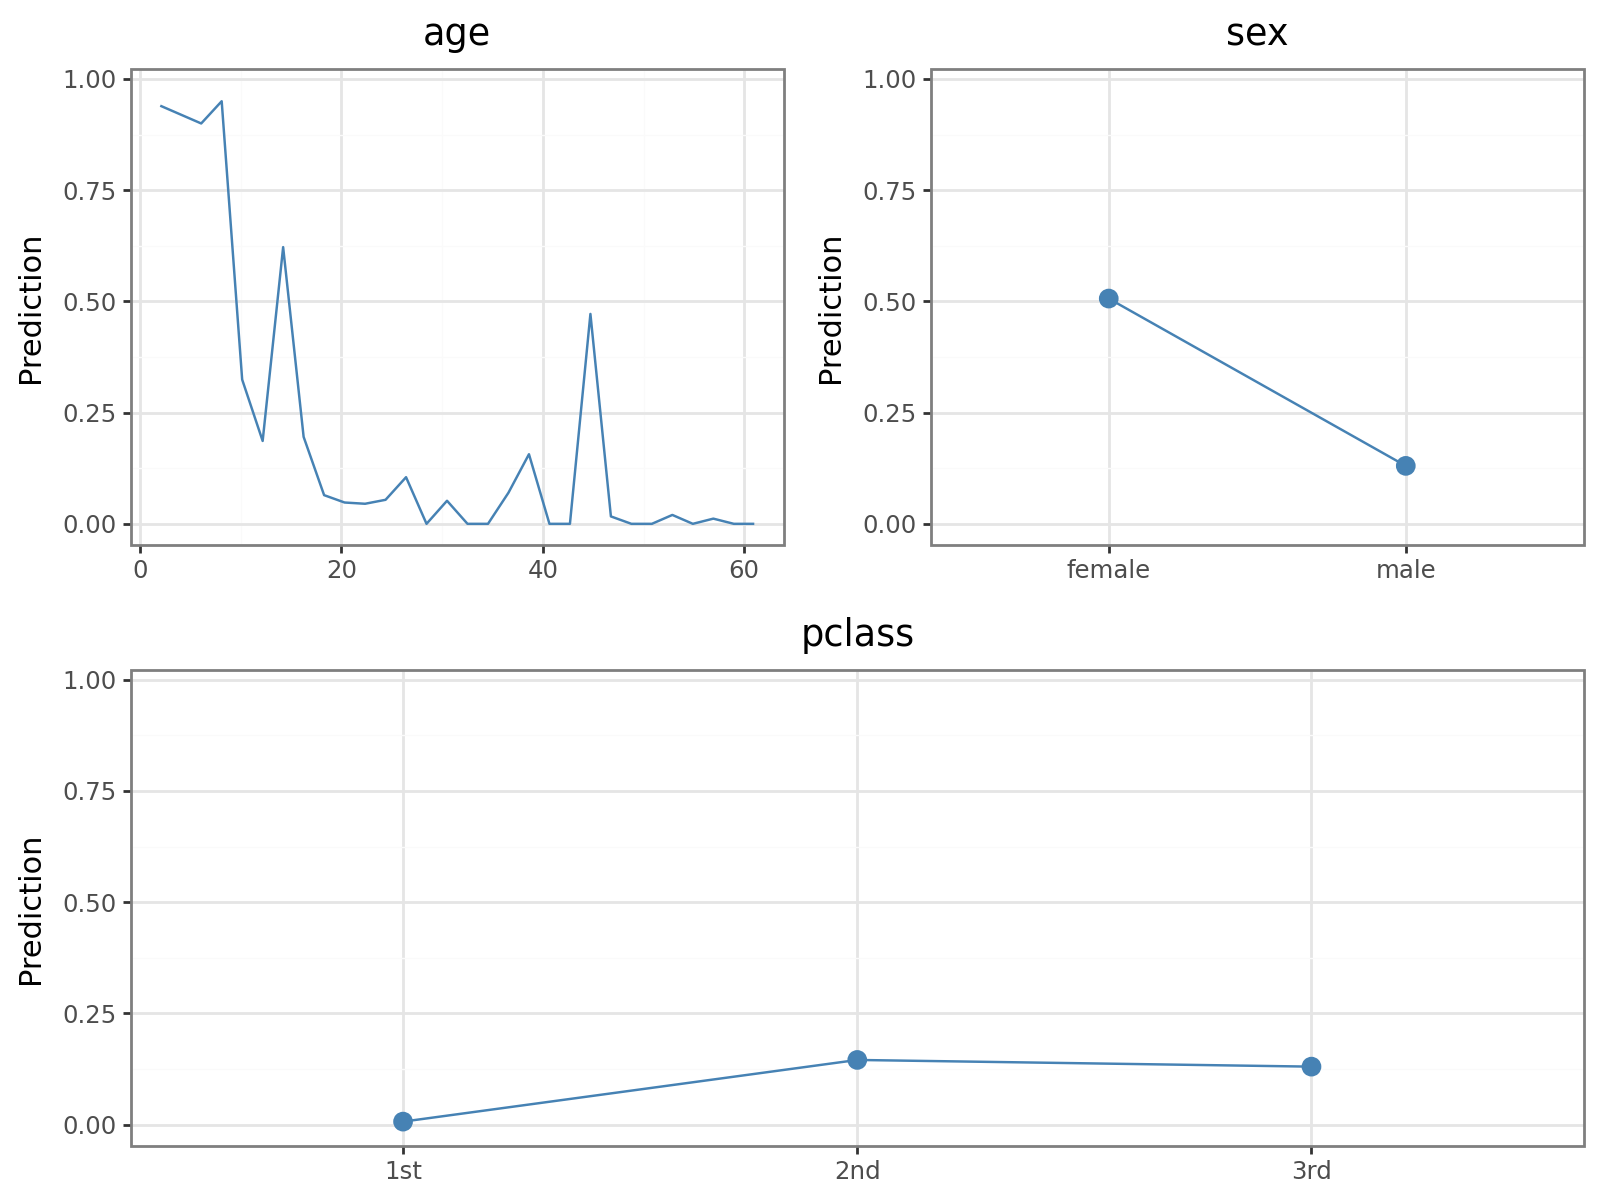

In [7]:
# pred_plot_sk (existing)
start = time.time()
plot_pred = pred_plot_sk(rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
rf_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {rf_clf_pred_time:.3f}s")
plot_pred

pdp_sk (fast): 0.045s


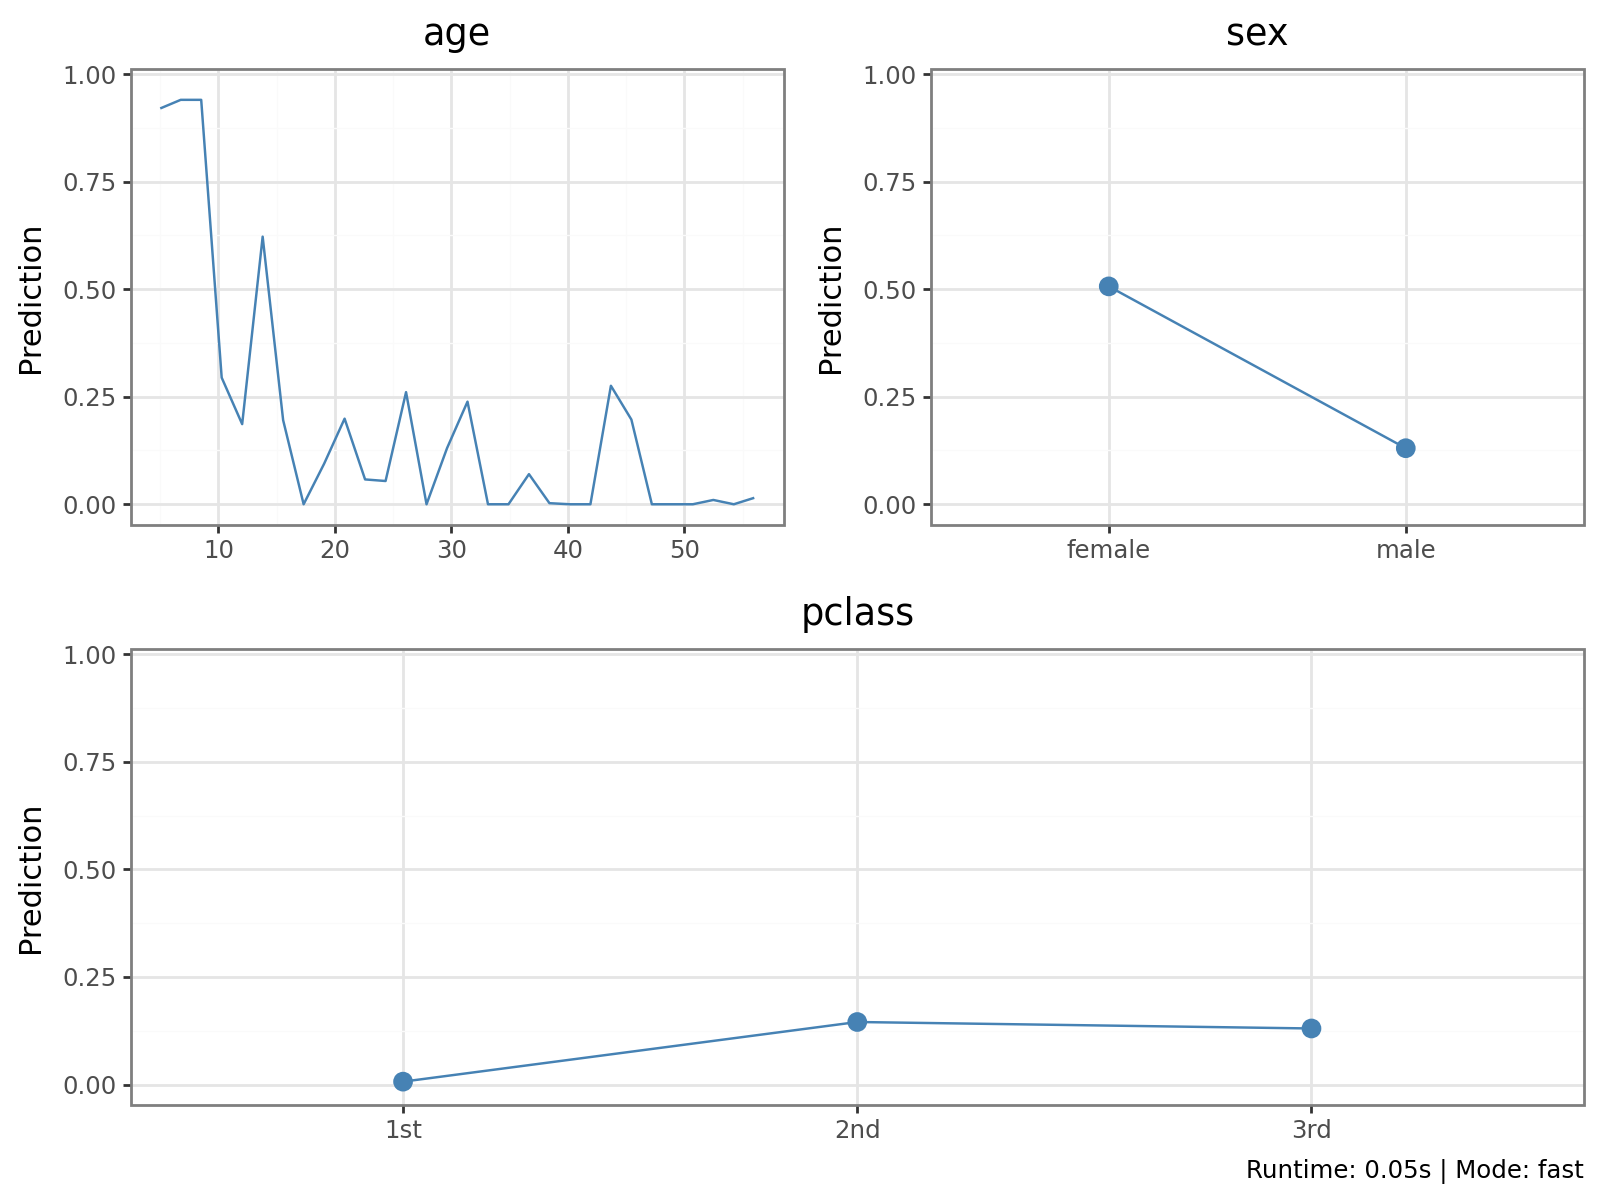

In [8]:
# pdp_sk - Fast Mode
plot_fast, data_fast, rf_clf_fast_time = pdp_sk(
    rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {rf_clf_fast_time:.3f}s")
plot_fast

pdp_sk (pdp): 0.319s


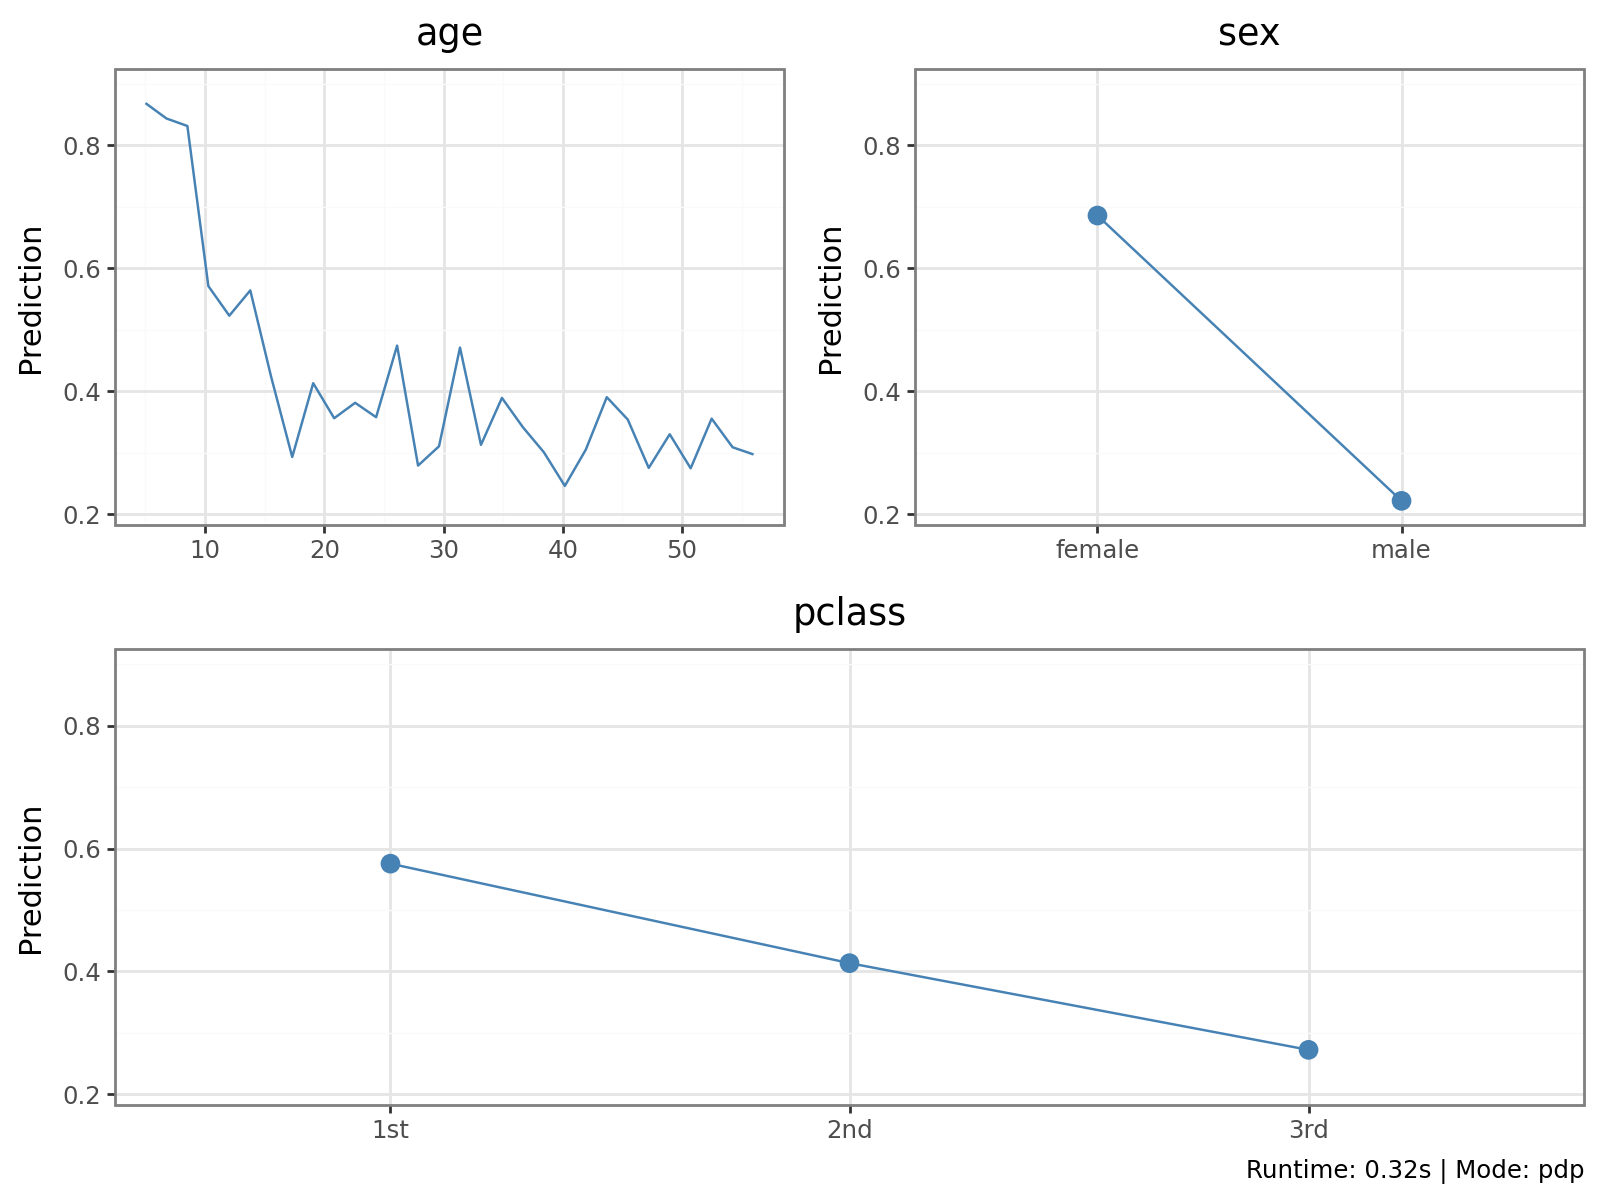

In [9]:
# pdp_sk - PDP Mode
plot_pdp, data_pdp, rf_clf_pdp_time = pdp_sk(
    rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {rf_clf_pdp_time:.3f}s")
plot_pdp

In [10]:
# Compare underlying data
print("Fast mode - age predictions:")
print(data_fast["age"].head(10))
print("\nPDP mode - age predictions:")
print(data_pdp["age"].head(10))

Fast mode - age predictions:
shape: (10, 2)
┌───────────┬────────────┐
│ age       ┆ prediction │
│ ---       ┆ ---        │
│ f64       ┆ f64        │
╞═══════════╪════════════╡
│ 5.0       ┆ 0.92       │
│ 6.758621  ┆ 0.94       │
│ 8.517241  ┆ 0.94       │
│ 10.275862 ┆ 0.294286   │
│ 12.034483 ┆ 0.186286   │
│ 13.793103 ┆ 0.622036   │
│ 15.551724 ┆ 0.195444   │
│ 17.310345 ┆ 0.0        │
│ 19.068966 ┆ 0.094138   │
│ 20.827586 ┆ 0.198971   │
└───────────┴────────────┘

PDP mode - age predictions:
shape: (10, 2)
┌───────────┬────────────┐
│ age       ┆ prediction │
│ ---       ┆ ---        │
│ f64       ┆ f64        │
╞═══════════╪════════════╡
│ 5.0       ┆ 0.868655   │
│ 6.758621  ┆ 0.843633   │
│ 8.517241  ┆ 0.831398   │
│ 10.275862 ┆ 0.571027   │
│ 12.034483 ┆ 0.522845   │
│ 13.793103 ┆ 0.564005   │
│ 15.551724 ┆ 0.422686   │
│ 17.310345 ┆ 0.293015   │
│ 19.068966 ┆ 0.413062   │
│ 20.827586 ┆ 0.356077   │
└───────────┴────────────┘


Interactions: 0.674s


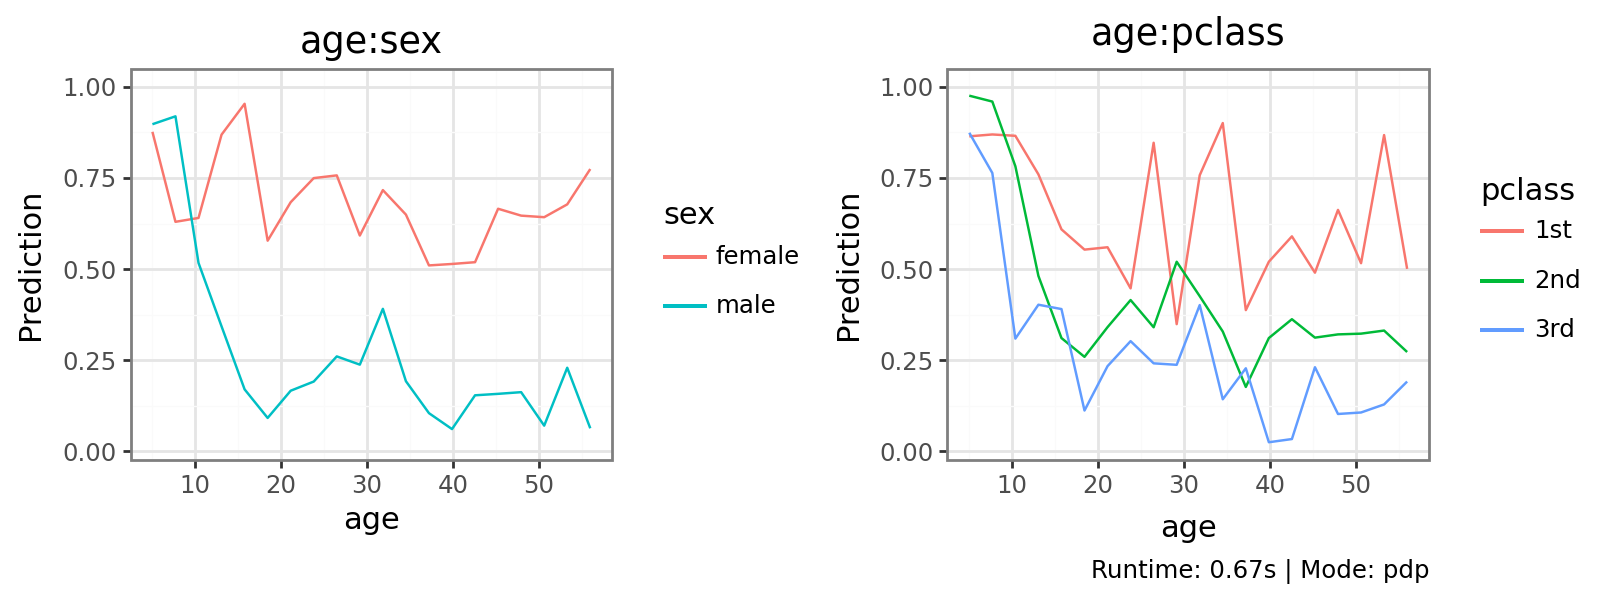

In [11]:
# Interaction plots
plot_int, _, rf_clf_int_time = pdp_sk(
    rf_clf.fitted, titanic, incl=[], incl_int=["age:sex", "age:pclass"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"Interactions: {rf_clf_int_time:.3f}s")
plot_int

## 1b. Random Forest Regression

In [12]:
rf_reg = rforest(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", n_estimators=100, random_state=1234,
)
rf_reg.summary()

Random Forest
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
OOB                  : True
Model type           : regression
Nr. of features      : (4, 6)
Nr. of observations  : 397
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
Model fit            :
    n    r2            mse        mae
  397  0.33  613466447.712  17724.573

Estimation data      :
shape: (5, 6)
┌───────────────┬─────────────┬──────────────┬──────────────┬───────────────┬───────────┐
│ yrs_since_phd ┆ yrs_service ┆ discipline_A ┆ discipline_B ┆ rank_AsstProf ┆ rank_Prof │
│ ---           ┆ ---         ┆ ---          ┆ ---          ┆ ---           ┆ ---       │
│ i32           ┆ i32         ┆ u8           ┆ u8           ┆ u8            ┆ u8        │
╞═══════════════╪═════════════╪══════════════╪══════════════╪═══════════════╪═══════════╡
│ 19   

pdp_sk regression: 0.469s


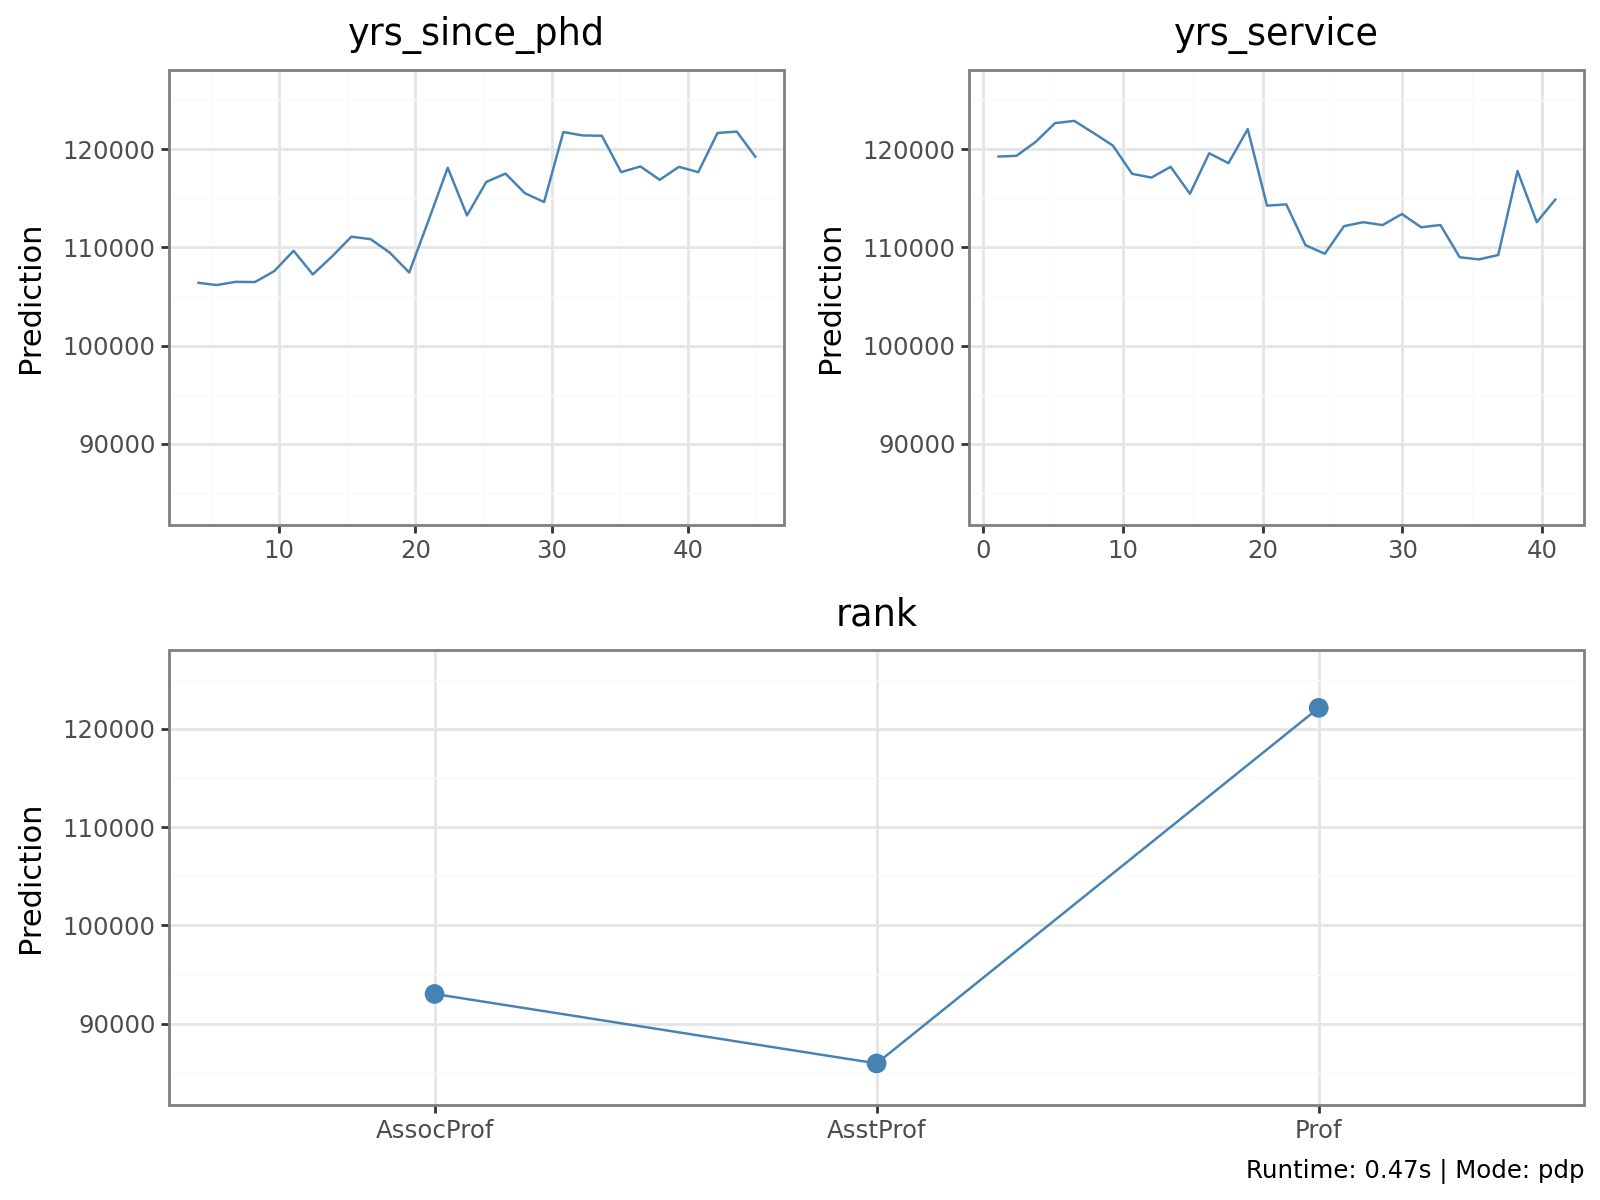

In [13]:
plot_rf_reg, _, rf_reg_pdp_time = pdp_sk(
    rf_reg.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {rf_reg_pdp_time:.3f}s")
plot_rf_reg

---
# 2. XGBoost

## 2a. XGBoost Classification

In [14]:
xgb_clf = xgboost(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", n_estimators=100, max_depth=4, random_state=1234,
)
xgb_clf.summary()

XGBoost
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
Model type           : classification
Nr. of features      : (4, 6)
Nr. of observations  : 1,043
n_estimators         : 100
max_depth            : 4
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.934

Estimation data      :
shape: (5, 6)
┌────────┬───────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 0     ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 0.9167 ┆ 1     ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1     

pred_plot_sk: 0.106s


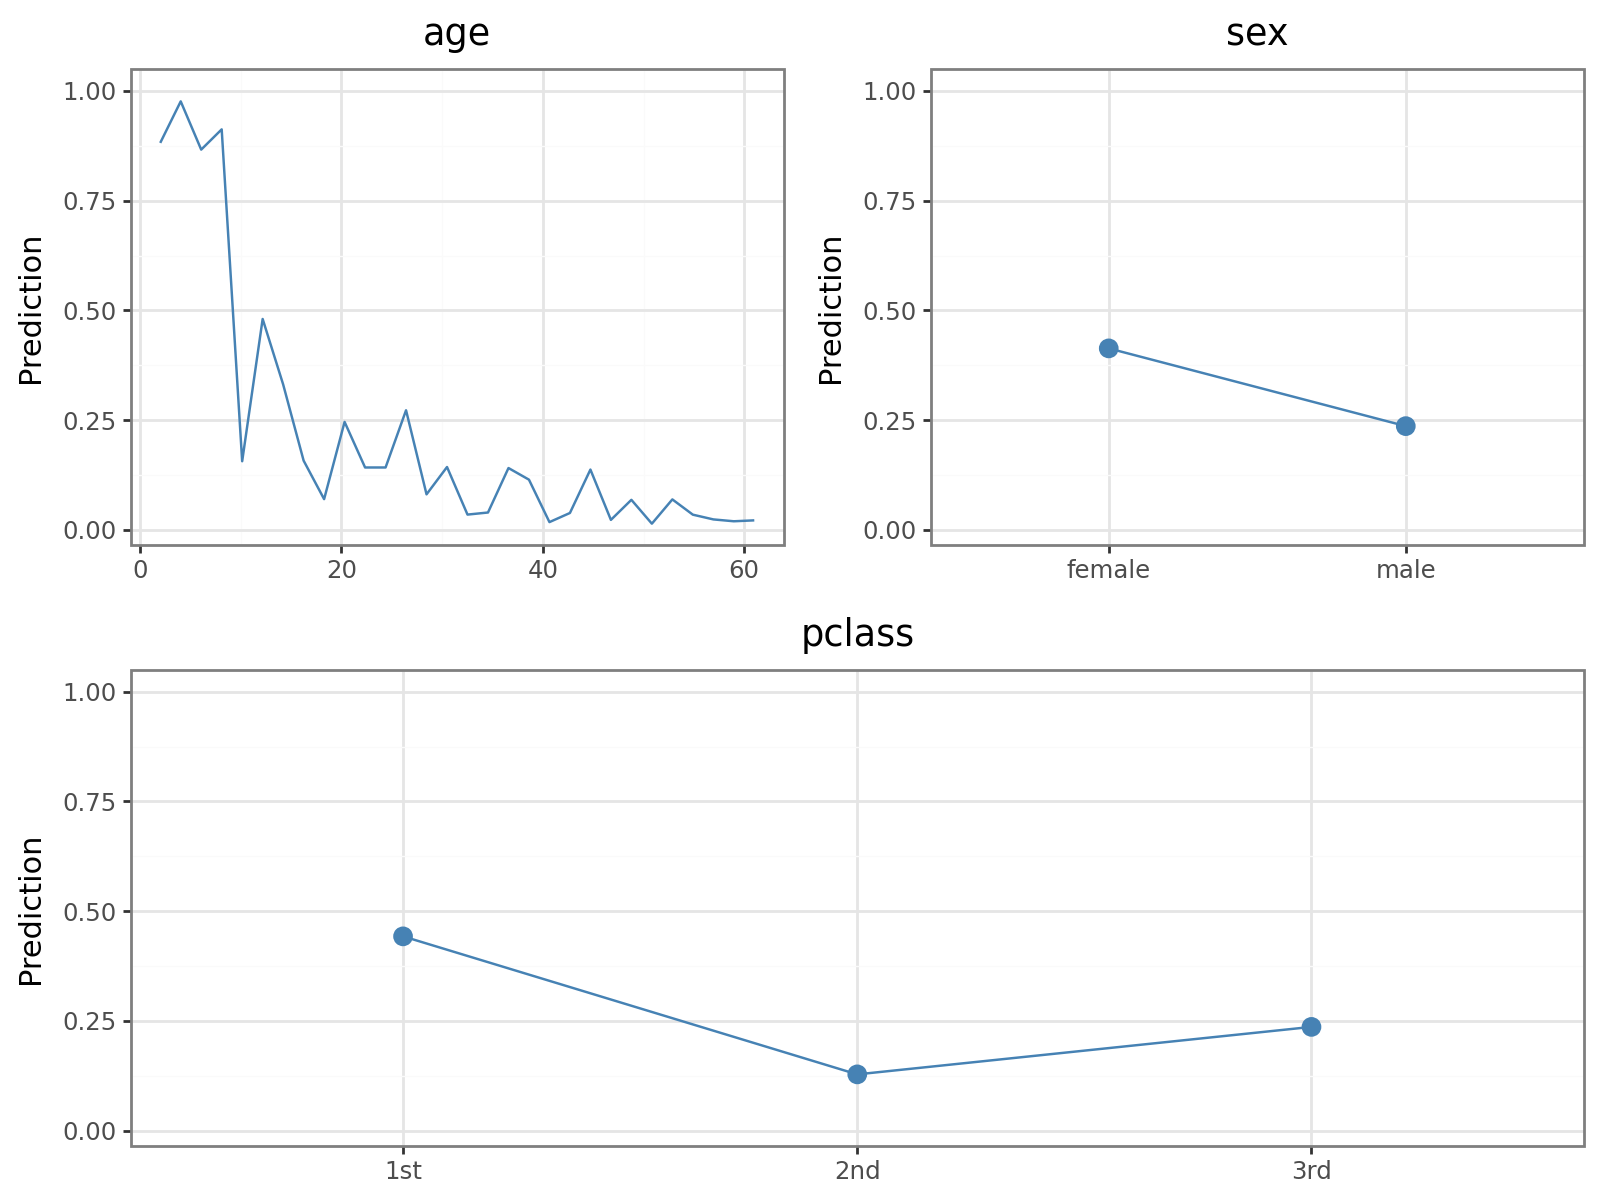

In [15]:
# pred_plot_sk
start = time.time()
plot_xgb_pred = pred_plot_sk(xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
xgb_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {xgb_clf_pred_time:.3f}s")
plot_xgb_pred

pdp_sk (fast): 0.050s


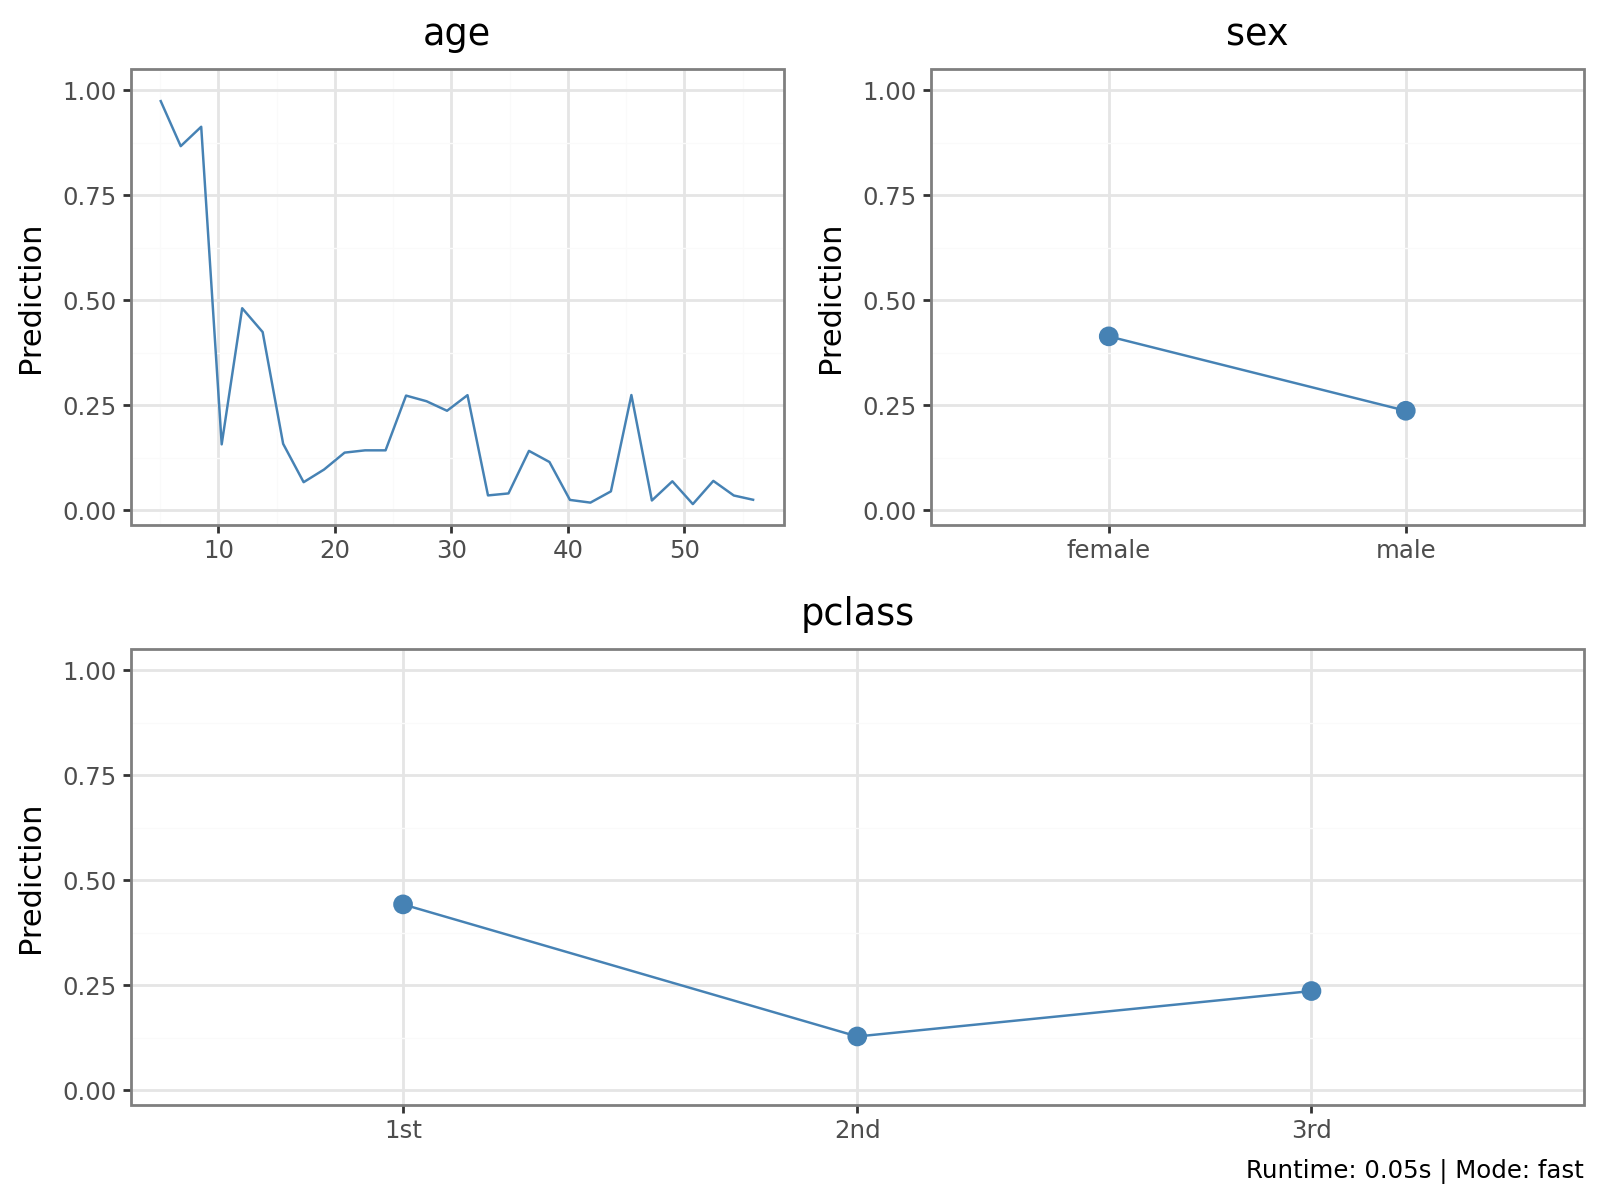

In [16]:
# pdp_sk - Fast
plot_xgb_fast, _, xgb_clf_fast_time = pdp_sk(
    xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {xgb_clf_fast_time:.3f}s")
plot_xgb_fast

pdp_sk (pdp): 0.142s


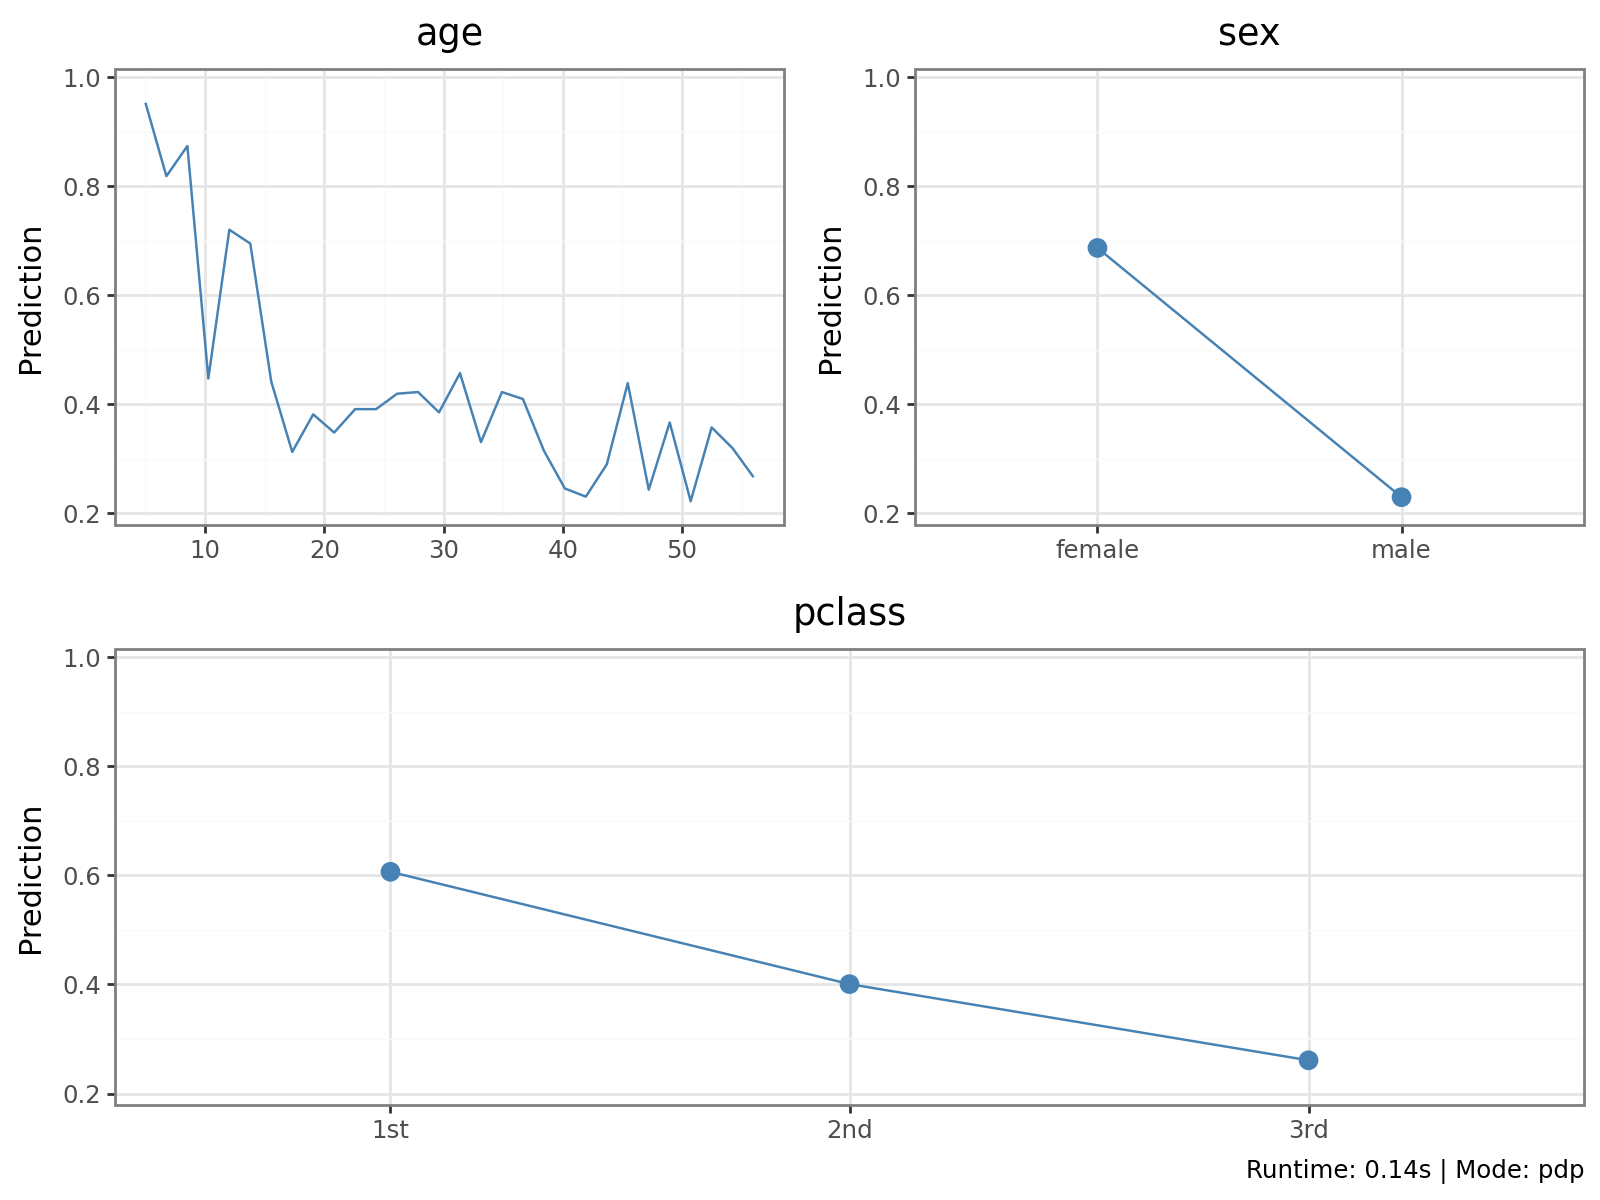

In [17]:
# pdp_sk - PDP
plot_xgb_pdp, _, xgb_clf_pdp_time = pdp_sk(
    xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {xgb_clf_pdp_time:.3f}s")
plot_xgb_pdp

## 2b. XGBoost Regression

In [18]:
xgb_reg = xgboost(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", n_estimators=100, max_depth=4, random_state=1234,
)
xgb_reg.summary()

XGBoost
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
Model type           : regression
Nr. of features      : (4, 6)
Nr. of observations  : 397
n_estimators         : 100
max_depth            : 4
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
Model fit            :
    n     r2            mse       mae
  397  0.845  141715178.394  7769.973

Estimation data      :
shape: (5, 6)
┌───────────────┬─────────────┬──────────────┬──────────────┬───────────────┬───────────┐
│ yrs_since_phd ┆ yrs_service ┆ discipline_A ┆ discipline_B ┆ rank_AsstProf ┆ rank_Prof │
│ ---           ┆ ---         ┆ ---          ┆ ---          ┆ ---           ┆ ---       │
│ i32           ┆ i32         ┆ u8           ┆ u8           ┆ u8            ┆ u8        │
╞═══════════════╪═════════════╪══════════════╪══════════════╪═══════════════╪═══════

pdp_sk regression: 0.318s


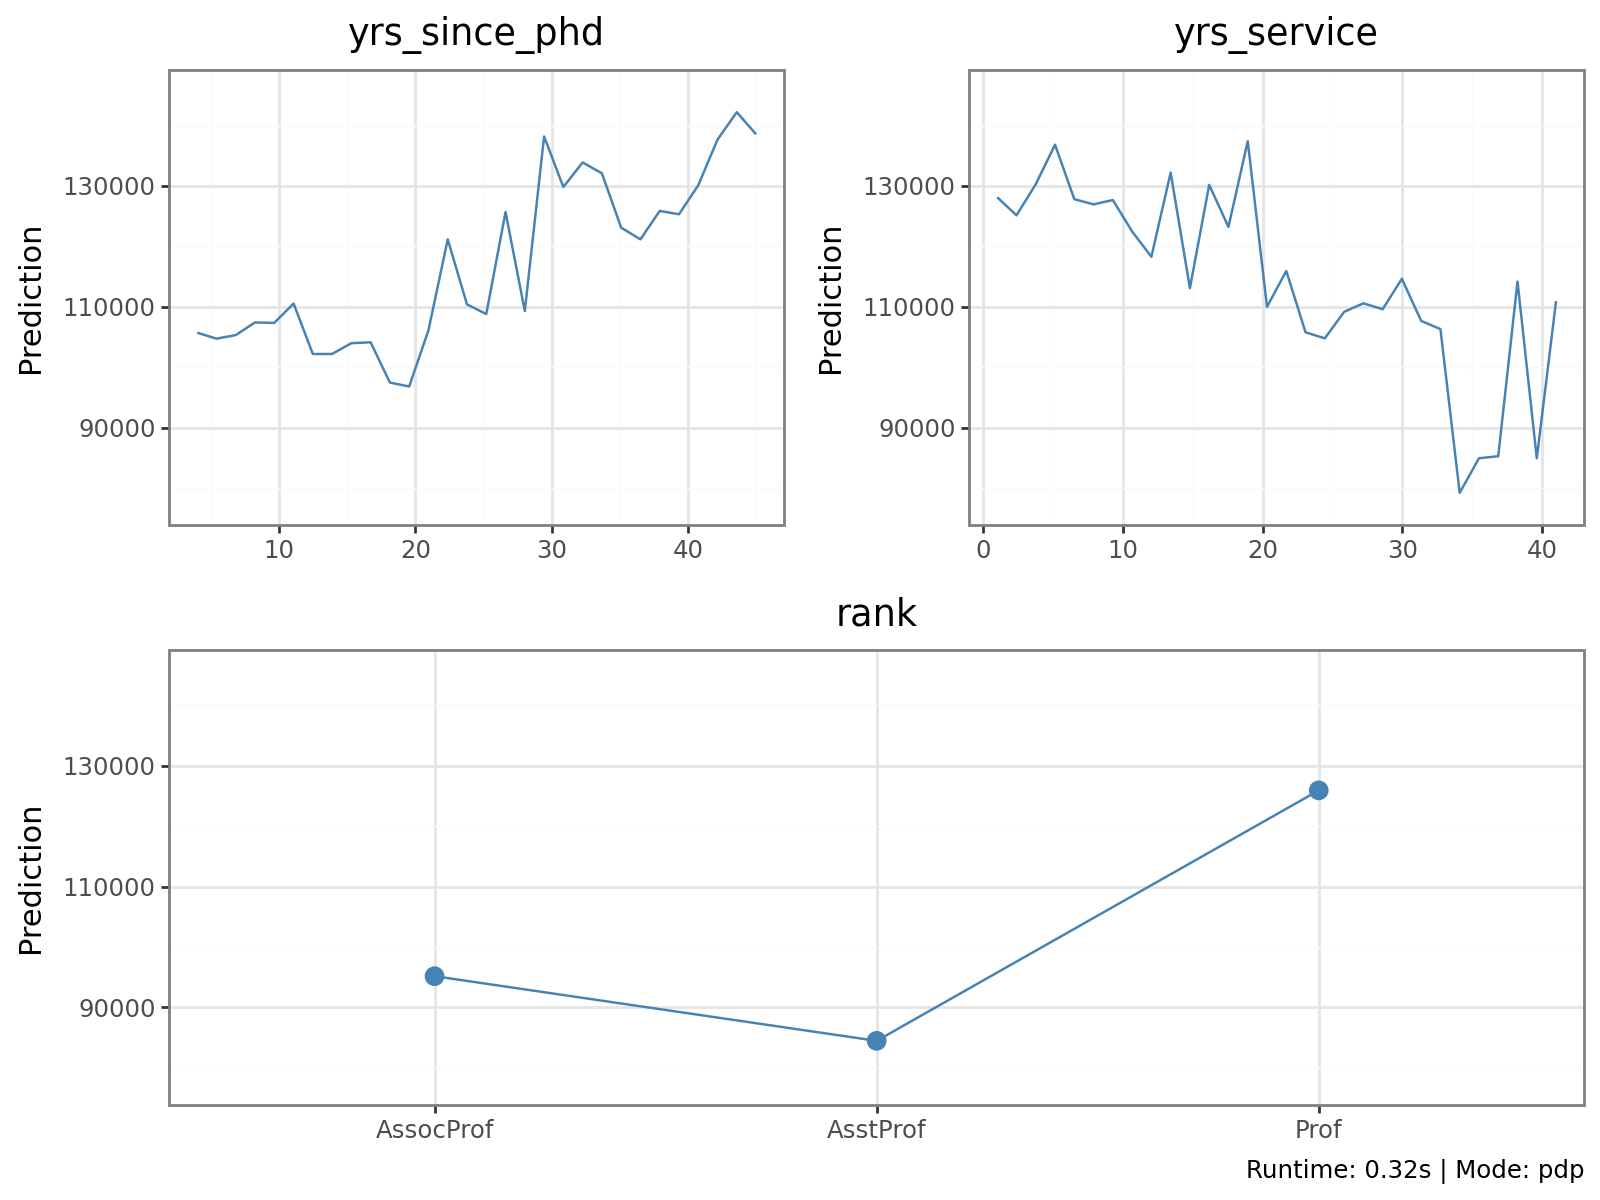

In [19]:
plot_xgb_reg, _, xgb_reg_pdp_time = pdp_sk(
    xgb_reg.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {xgb_reg_pdp_time:.3f}s")
plot_xgb_reg

---
# 3. MLP Neural Network

## 3a. MLP Classification

In [20]:
mlp_clf = mlp(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", hidden_layer_sizes=(10, 5), activation="tanh", random_state=1234,
)
mlp_clf.summary()

Multi-layer Perceptron (NN)
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
Model type           : classification
Nr. of features      : (4, 5)
Nr. of weights       : 121
Nr. of observations  : 1,043
Hidden_layer_sizes   : (10, 5)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.92

Raw data             :
shape: (5, 4)
┌────────┬────────┬────────┬───────┐
│ age    ┆ sex    ┆ pclass ┆ sibsp │
│ ---    ┆ ---    ┆ ---    ┆ ---   │
│ f64    ┆ cat    ┆ cat    ┆ i32   │
╞════════╪════════╪════════╪═══════╡
│ 29.0   ┆ female ┆ 1st    ┆ 0     │
│ 0.9167 ┆ male   ┆ 1st    ┆ 1     │
│ 2.0    ┆ female ┆ 1st    ┆ 1     │
│ 30.0   ┆ male   ┆ 1st    ┆ 1     │
│ 25.0   ┆ female ┆ 1st    ┆ 1     │
└────────┴────────┴────────┴───────┘

pred_plot_sk: 0.048s


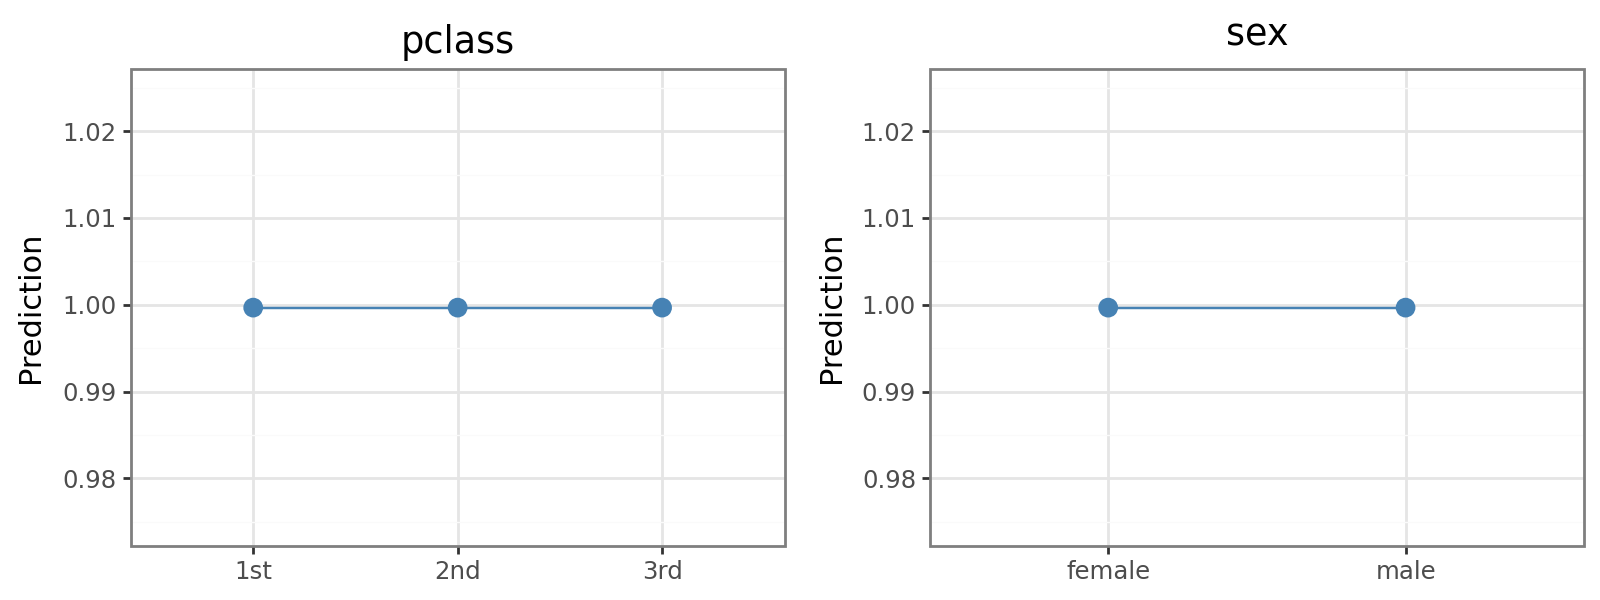

In [23]:
# pred_plot_sk
start = time.time()
plot_mlp_pred = pred_plot_sk(mlp_clf.fitted, titanic, incl=["pclass", "sex"], nnv=30)
mlp_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {mlp_clf_pred_time:.3f}s")
plot_mlp_pred

In [ ]:
# pdp_sk - Fast
plot_mlp_fast, _, mlp_clf_fast_time = pdp_sk(
    mlp_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {mlp_clf_fast_time:.3f}s")
plot_mlp_fast

In [ ]:
# pdp_sk - PDP
plot_mlp_pdp, _, mlp_clf_pdp_time = pdp_sk(
    mlp_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {mlp_clf_pdp_time:.3f}s")
plot_mlp_pdp

## 3b. MLP Regression

In [ ]:
mlp_reg = mlp(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", hidden_layer_sizes=(10, 5), activation="tanh", random_state=1234,
)
mlp_reg.summary()

In [ ]:
plot_mlp_reg, _, mlp_reg_pdp_time = pdp_sk(
    mlp_reg.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {mlp_reg_pdp_time:.3f}s")
plot_mlp_reg

---
# 4. Logistic Regression (pyrsm.logistic)

In [ ]:
log_model = logistic(
    data=titanic,
    rvar="survived", lev="Yes", evar=clf_evars,
)
log_model.summary()

In [ ]:
# pred_plot_sm (existing)
start = time.time()
plot_log_pred = pred_plot_sm(log_model.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
log_pred_time = time.time() - start
print(f"pred_plot_sm: {log_pred_time:.3f}s")
plot_log_pred

In [ ]:
# pdp_sm - Fast
plot_log_fast, _, log_fast_time = pdp_sm(
    log_model.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sm (fast): {log_fast_time:.3f}s")
plot_log_fast

In [ ]:
# pdp_sm - PDP
plot_log_pdp, _, log_pdp_time = pdp_sm(
    log_model.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sm (pdp): {log_pdp_time:.3f}s")
plot_log_pdp

In [ ]:
# Interaction plots
plot_log_int, _, log_int_time = pdp_sm(
    log_model.fitted, titanic, incl=[], incl_int=["age:sex"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"Interactions: {log_int_time:.3f}s")
plot_log_int

---
# 5. Linear Regression (pyrsm.regress)

In [ ]:
ols_model = regress(
    data=salary,
    rvar="salary", evar=reg_evars,
)
ols_model.summary()

In [ ]:
# pred_plot_sm (existing)
start = time.time()
plot_ols_pred = pred_plot_sm(ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], nnv=30)
ols_pred_time = time.time() - start
print(f"pred_plot_sm: {ols_pred_time:.3f}s")
plot_ols_pred

In [ ]:
# pdp_sm - Fast
plot_ols_fast, _, ols_fast_time = pdp_sm(
    ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], mode="fast", grid_resolution=30
)
print(f"pdp_sm (fast): {ols_fast_time:.3f}s")
plot_ols_fast

In [ ]:
# pdp_sm - PDP
plot_ols_pdp, _, ols_pdp_time = pdp_sm(
    ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sm (pdp): {ols_pdp_time:.3f}s")
plot_ols_pdp

In [ ]:
# Numeric-numeric interaction
plot_ols_int, _, ols_int_time = pdp_sm(
    ols_model.fitted, salary, incl=[], incl_int=["yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=200, grid_resolution=20
)
print(f"Num-num interaction: {ols_int_time:.3f}s")
plot_ols_int

---
# 6. Timing Summary

In [ ]:
print("=" * 65)
print("TIMING SUMMARY")
print("=" * 65)

print(f"\n--- SKLEARN MODELS (pdp_sk) ---")

print(f"\nRandom Forest Classification (n={titanic.shape[0]}):")
print(f"  pred_plot_sk:     {rf_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {rf_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {rf_clf_pdp_time:.3f}s")

print(f"\nXGBoost Classification:")
print(f"  pred_plot_sk:     {xgb_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {xgb_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {xgb_clf_pdp_time:.3f}s")

print(f"\nMLP Classification:")
print(f"  pred_plot_sk:     {mlp_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {mlp_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {mlp_clf_pdp_time:.3f}s")

print(f"\n--- STATSMODELS (pdp_sm) ---")

print(f"\nLogistic Regression (n={titanic.shape[0]}):")
print(f"  pred_plot_sm:     {log_pred_time:.3f}s")
print(f"  pdp_sm (fast):    {log_fast_time:.3f}s")
print(f"  pdp_sm (pdp):     {log_pdp_time:.3f}s")

print(f"\nOLS Regression (n={salary.shape[0]}):")
print(f"  pred_plot_sm:     {ols_pred_time:.3f}s")
print(f"  pdp_sm (fast):    {ols_fast_time:.3f}s")
print(f"  pdp_sm (pdp):     {ols_pdp_time:.3f}s")

---
# Notes

- **Fast mode** is similar to `pred_plot_*` - sets other variables to mean/mode
- **PDP mode** averages predictions across the data distribution (true partial dependence)
- PDP mode is slower but gives more accurate marginal effects
- Use `n_sample` to control speed vs accuracy tradeoff in PDP mode
- Both functions return `(plot, data_dict, runtime)` for inspection and testing
- `pdp_sk` works with sklearn models (rforest, xgboost, mlp)
- `pdp_sm` works with statsmodels models (logistic, regress)